In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.datasets import make_classification
import matplotlib.patches as patches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys
import os

current_dir = os.getcwd() 
parent_dir = os.path.join(current_dir, '..', '..')
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from in2D.classifying.classes.simplex_tree_classifier import SimplexTreeClassifier
from in2D.classifying.classes.utilss.plane_equation import PlaneEquation

In [2]:
def make_meshgrid(x, y, h=.01):
    x_min, x_max = x.min() , x.max()
    y_min, y_max = y.min() , y.max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, xy, **params):
    Z = clf.predict(xy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out


In [3]:
N=1000
C=1000
gamma=0.01
D=2 #dimension
t=8 #polytope order

X = np.random.normal(0,1,(N,D))
ws= np.random.normal(0,1,(t,D))
ws = ws / (np.linalg.norm(ws,axis=1).reshape(-1,1))

u=np.random.uniform(0,1,(N,1))
X=X/(np.linalg.norm(X,axis=1).reshape(-1,1))*(u**(1/D))

y=np.ones(N)

for index in range(N):
    z = 1
    for w in ws :
        if((X[index].dot(w)- 0.5 - gamma) > 0):
            z = -1
        else :
            if ((X[index].dot(w) - 0.4 -gamma) > 0):
                z =0
    y[index]=z

X=(X[y!= 0]+ [1,1])/2
y=y[y!= 0]

print("Dataset created:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"Classes: {np.unique(y)}")


Dataset created:
X shape: (778, 2)
y shape: (778,)
Classes: [-1.  1.]


### Redundent Planes Detection

In [4]:
MAX_SUBDIVISION = 6

## Crossed Plane Detection


Root simplex vertices: [(-0.043493312955288924, -0.046168366724527024), (2.1302892646134297, -0.046168366724527024), (-0.043493312955288924, 2.1353226078504215)]

Subdivision Level 1:
(778, 4)
  Found 0 redundant simplices

Subdivision Level 2:
(778, 7)
  Found 0 redundant simplices

Subdivision Level 3:
(778, 16)
  Found 9 redundant simplices

Subdivision Level 4:
(778, 43)
  Found 39 redundant simplices

Subdivision Level 5:
(778, 124)
  Found 159 redundant simplices

Subdivision Level 6:
(778, 367)
  Found 546 redundant simplices


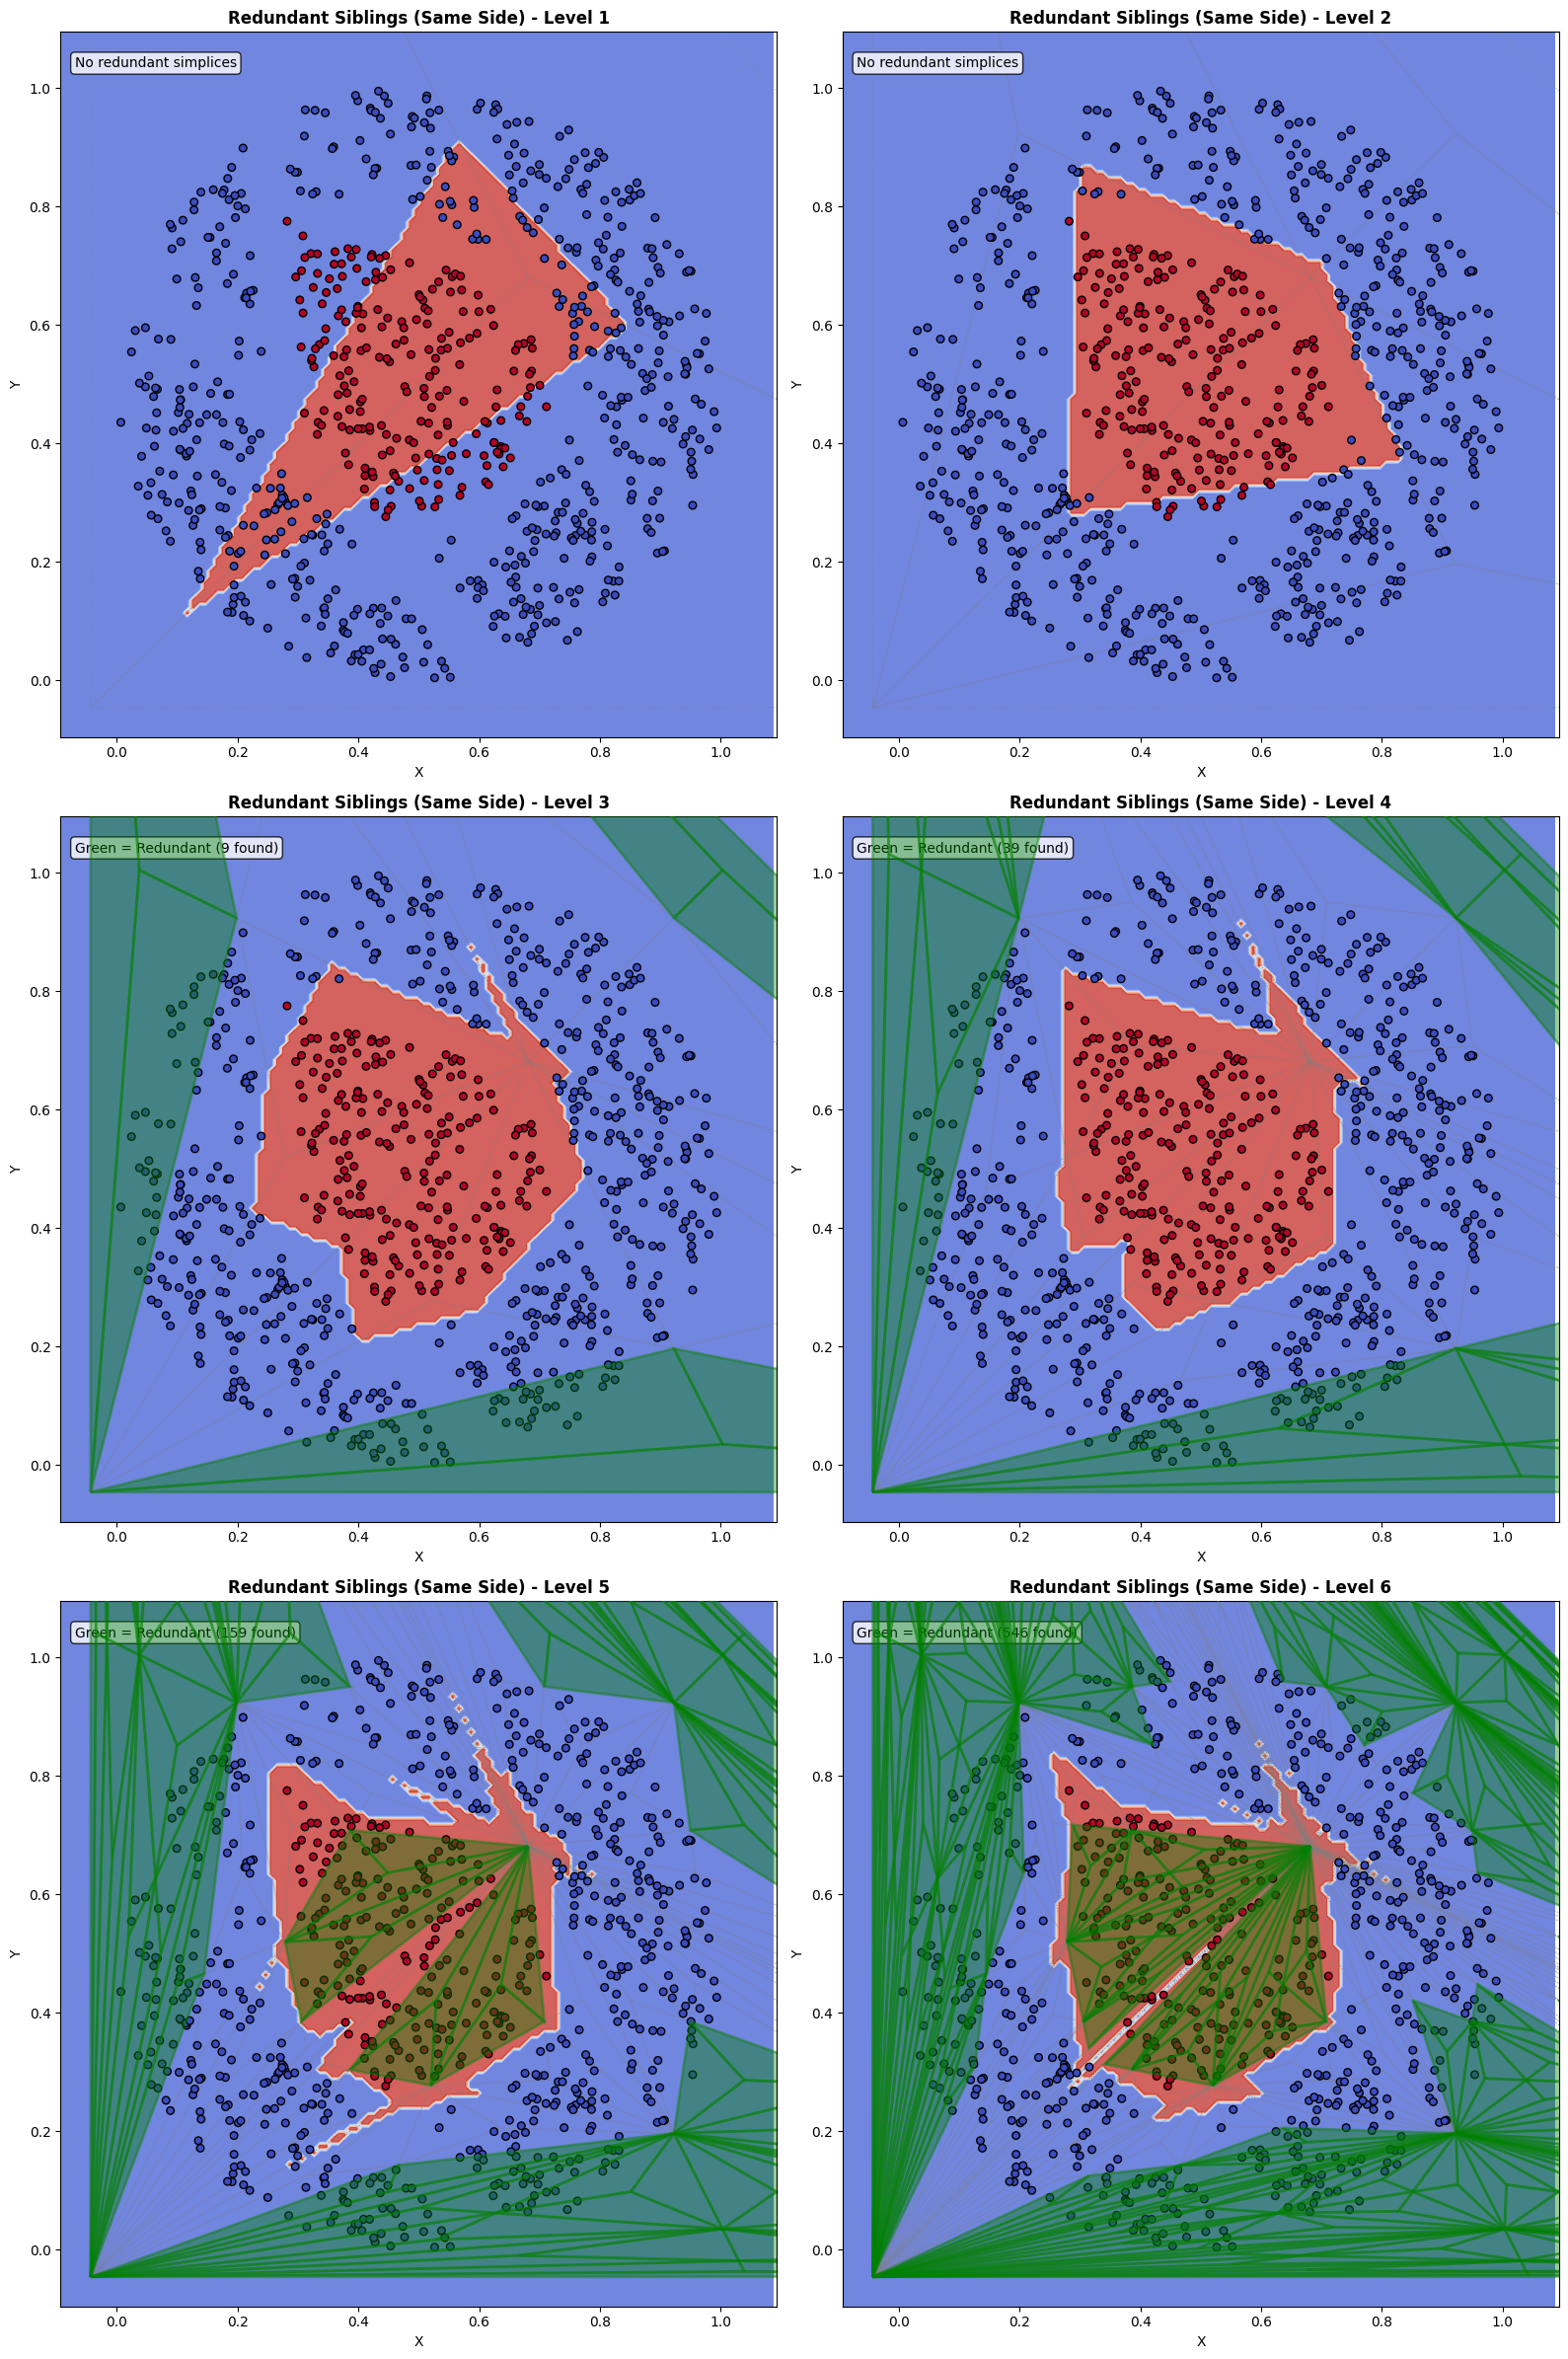

In [ ]:
# Redundant Siblings Test

# Compute root simplex from data bounds (with small margin)
margin = 0.05
data_x_min, data_x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
data_y_min, data_y_max = X[:, 1].min() - margin, X[:, 1].max() + margin

# Create a right triangle that covers the data bounding box
root_vertices = [
    (data_x_min, data_y_min),
    (data_x_max + (data_x_max - data_x_min), data_y_min),
    (data_x_min, data_y_max + (data_y_max - data_y_min))
]
print(f"Root simplex vertices: {root_vertices}")

cols = 2
rows = int(np.ceil(MAX_SUBDIVISION / cols))
fig, sub = plt.subplots(rows, cols, figsize=(cols*8, rows*8))
axes = np.atleast_1d(sub).ravel()

# Plot limits match the data
x_min, x_max = data_x_min - 0.05, data_x_max + 0.05
y_min, y_max = data_y_min - 0.05, data_y_max + 0.05
xx, yy = make_meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))

for k, ax in zip(range(1, MAX_SUBDIVISION + 1), axes):
    print(f"\nSubdivision Level {k}:")
    
    # 1. Build the classifier
    model = SimplexTreeClassifier(
        vertices=root_vertices,
        regularization=C,
        subdivision_levels=k,
        classifier_type='linear_svc'
    )
    model.fit(X, y)
    
    # 2. Find same-side simplices
    same_side_simplex_keys = model.find_same_side_simplices()
    
    print(f"  Found {len(same_side_simplex_keys)} same-side simplices")

    # Plot background classification
    xy = model.transform(np.vstack([xx.ravel(), yy.ravel()]).T)
    plot_contours(ax, model.classifier, xx, yy, xy, cmap=plt.cm.coolwarm, alpha=0.8)
    
    # Plot data points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, s=30, 
               edgecolors='k', linewidth=1, zorder=5)
    
    # Plot simplex boundaries
    boundaries = model.get_simplex_boundaries()
    for boundary in boundaries:
        if len(boundary) >= 3:
            closed_boundary = boundary + [boundary[0]]
            bx, by = zip(*closed_boundary)
            ax.plot(bx, by, 'gray', linestyle=':', linewidth=0.8, alpha=0.5)

    # 3. Highlight same-side simplices in GREEN
    for leaf in model.leaf_simplexes:
        simplex_key = frozenset(leaf.vertex_indices)
        if simplex_key in same_side_simplex_keys:
            vertices = np.array(leaf.vertices)
            poly = patches.Polygon(vertices, closed=True, 
                                 facecolor='green', alpha=0.4, 
                                 edgecolor='green', linewidth=2, zorder=6)
            ax.add_patch(poly)
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_title(f"Same Side Simplices - Level {k}", fontsize=12, fontweight='bold')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    
    status_text = f'Green = Same Side ({len(same_side_simplex_keys)} found)' if same_side_simplex_keys else 'No same-side simplices'
    ax.text(0.02, 0.95, status_text, transform=ax.transAxes,
            fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

for ax in axes[MAX_SUBDIVISION:]:
    ax.axis('off')

plt.tight_layout()
plt.show()